# Predict Catalogue Demand

## The Business Problem

You recently started working for a company that manufactures and sells high-end home goods. Last year the company sent out its first print catalog, and is preparing to send out this year's catalog in the coming months. The company has 250 new customers from their mailing list that they want to send the catalog to.

Your manager has been asked to determine how much profit the company can expect from sending a catalog to these customers. You, the business analyst, are assigned to help your manager run the numbers. While fairly knowledgeable about data analysis, your manager is not very familiar with predictive models.

You’ve been asked to predict the expected profit from these 250 new customers. Management does not want to send the catalog out to these new customers unless the expected profit contribution exceeds \$10,000.

## Details
* The costs of printing and distributing is \$6.50 per catalog.
* The average gross margin (price - cost) on all products sold through the catalog is 50%.
* Make sure to multiply your revenue by the gross margin first before you subtract out the $6.50 cost when calculating your profit.

Write a short report with your recommendations outlining your reasons why the company should go with your recommendations to your manager.

In [1]:
# for seaborn distplot
def _revrt(X,m=None):
    """
    Inverse of forrt. Equivalent to Munro (1976) REVRT routine.
    """
    if m is None:
        m = len(X)
    i = int(m // 2+1)
    y = X[:i] + np.r_[0,X[i:],0]*1j
    return np.fft.irfft(y)*m

from statsmodels.nonparametric import kdetools

# replace the implementation with new method.
kdetools.revrt = _revrt

# import seaborn AFTER replacing the method. 
import seaborn as sns
sns.set()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from IPython.display import HTML, display

In [4]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Ordinary least square assumptions
1.	**Linearity**: A linear relationship exists between the dependent and predictor variables. If no linear relationship exists, linear regression isn't the correct model to explain our data.
2.	**No multicollinearity**: Predictor variables are not collinear, i.e., they aren't highly correlated. If the predictors are highly correlated, try removing one or more of them. Since additional predictors are supplying redundant information, removing them shouldn't drastically reduce the Adj. R-squared.
3.	**Zero conditional mean**: The average of the distances (or residuals) between the observations and the trend line is zero. Some will be positive, others negative, but they won't be biased toward a set of values.
4.	**Homoskedasticity**: The certainty (or uncertainty) of our dependent variable is equal across all values of a predictor variable; that is, there is no pattern in the residuals. In statistical jargon, the variance is constant.
5.	**No autocorrelation (serial correlation)**: Autocorrelation is when a variable is correlated with itself across observations. For example, a stock price might be serially correlated if one day's stock price impacts the next day's stock price.

---

# For training

This dataset includes the following information on about 2,300 customers. Important: You should build your model on this dataset and not p1-mailinglist.xlsx.

In [5]:
customers = pd.read_excel('p1-customers.xlsx')

In [6]:
#checking if any value is missing
print(customers.isnull().any())

Name                          False
Customer_Segment              False
Customer_ID                   False
Address                       False
City                          False
State                         False
ZIP                           False
Avg_Sale_Amount               False
Store_Number                  False
Responded_to_Last_Catalog     False
Avg_Num_Products_Purchased    False
#_Years_as_Customer           False
dtype: bool


In [7]:
customers.shape

(2375, 12)

We have 2375 customers in the list and 12 features.

In [8]:
customers.head()

,Name,Customer_Segment,Customer_ID,Address,City,State,ZIP,Avg_Sale_Amount,Store_Number,Responded_to_Last_Catalog,Avg_Num_Products_Purchased,#_Years_as_Customer
0,Pamela Wright,Store Mailing List,2,376 S Jasmine St,Denver,CO,80224,227.90,100,No,1,6
1,Danell Valdez,Store Mailing List,7,12066 E Lake Cir,Greenwood Village,CO,80111,55.00,105,Yes,1,6
2,Jessica Rinehart,Store Mailing List,8,7225 S Gaylord St,Centennial,CO,80122,212.57,101,No,1,3
3,Nancy Clark,Store Mailing List,9,4497 Cornish Way,Denver,CO,80239,195.31,105,Yes,1,6
4,Andrea Brun,Store Mailing List,10,2316 E 5th Ave,Denver,CO,80206,110.55,100,Yes,1,2


`ZIP` and `Store_Number` are integers, but their nature is categorical. Hence, we should convert them.

In [9]:
customers.ZIP = customers.ZIP.astype('category')
customers.Store_Number = customers.Store_Number.astype('category')

In [10]:
customers = customers.drop(['Name', 'Address', 'Customer_ID', 'State'], axis=1)

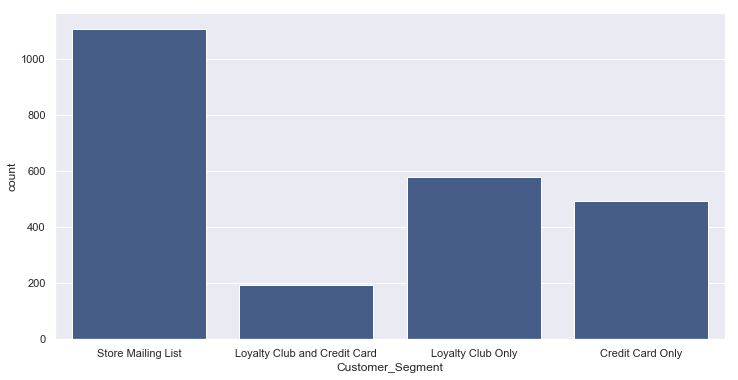

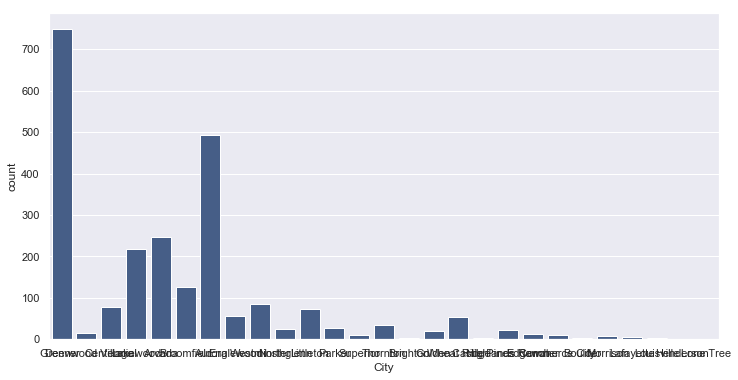

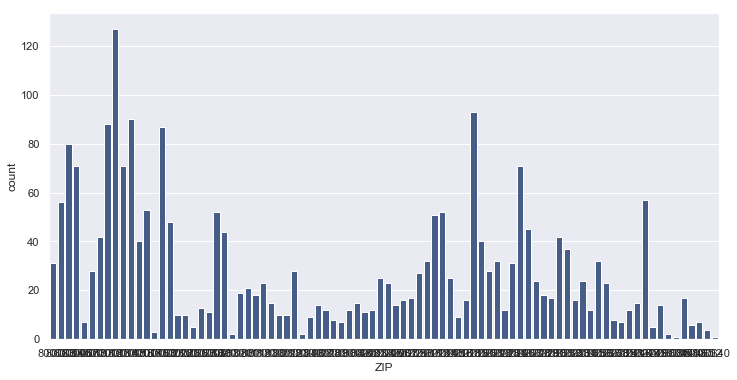

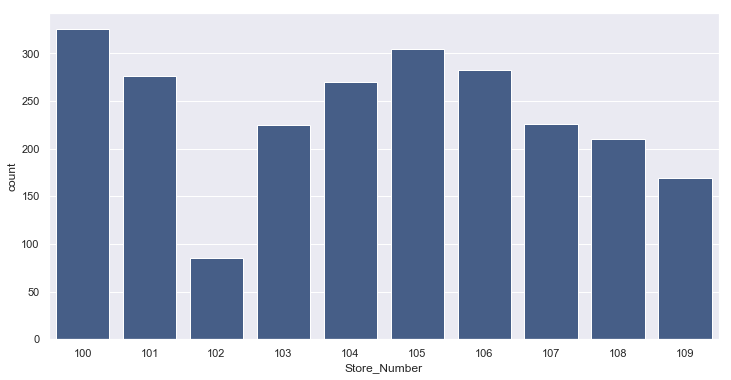

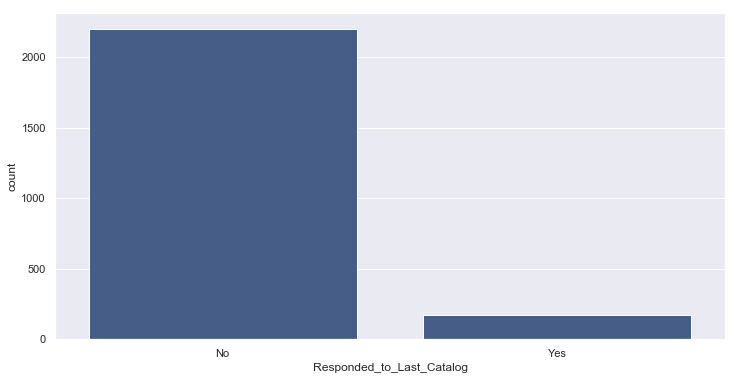

In [11]:
for col in customers.select_dtypes(include=['object', 'category']).columns:
    fig = plt.figure(figsize=(12,6))
    sns.countplot(x=col, data=customers, color=sns.xkcd_rgb["denim blue"])
    plt.show()

`Responded_to_Last_Catalog` is not in the test dataset, so let's drop it too.

In [12]:
customers = customers.drop(['Responded_to_Last_Catalog'], axis=1)

In [13]:
customers.shape

(2375, 7)

Let's take a look at what we have now:

In [14]:
customers.describe(include='all')

,Customer_Segment,City,ZIP,Avg_Sale_Amount,Store_Number,Avg_Num_Products_Purchased,#_Years_as_Customer
count,2375,2375,2375.0,2375.000000,2375.0,2375.000000,2375.000000
unique,4,27,86.0,NaN,10.0,NaN,NaN
top,Store Mailing List,Denver,80013.0,NaN,100.0,NaN,NaN
freq,1108,750,127.0,NaN,326.0,NaN,NaN
mean,NaN,NaN,NaN,399.774093,NaN,3.347368,4.500632
std,NaN,NaN,NaN,340.115808,NaN,2.738568,2.309986
min,NaN,NaN,NaN,1.220000,NaN,1.000000,1.000000
25%,NaN,NaN,NaN,168.925000,NaN,1.000000,2.000000
50%,NaN,NaN,NaN,281.320000,NaN,3.000000,5.000000
75%,NaN,NaN,NaN,572.400000,NaN,5.000000,6.000000


We can now analyze the relationships between the features.

/Users/Claudi/anaconda/lib/python3.5/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


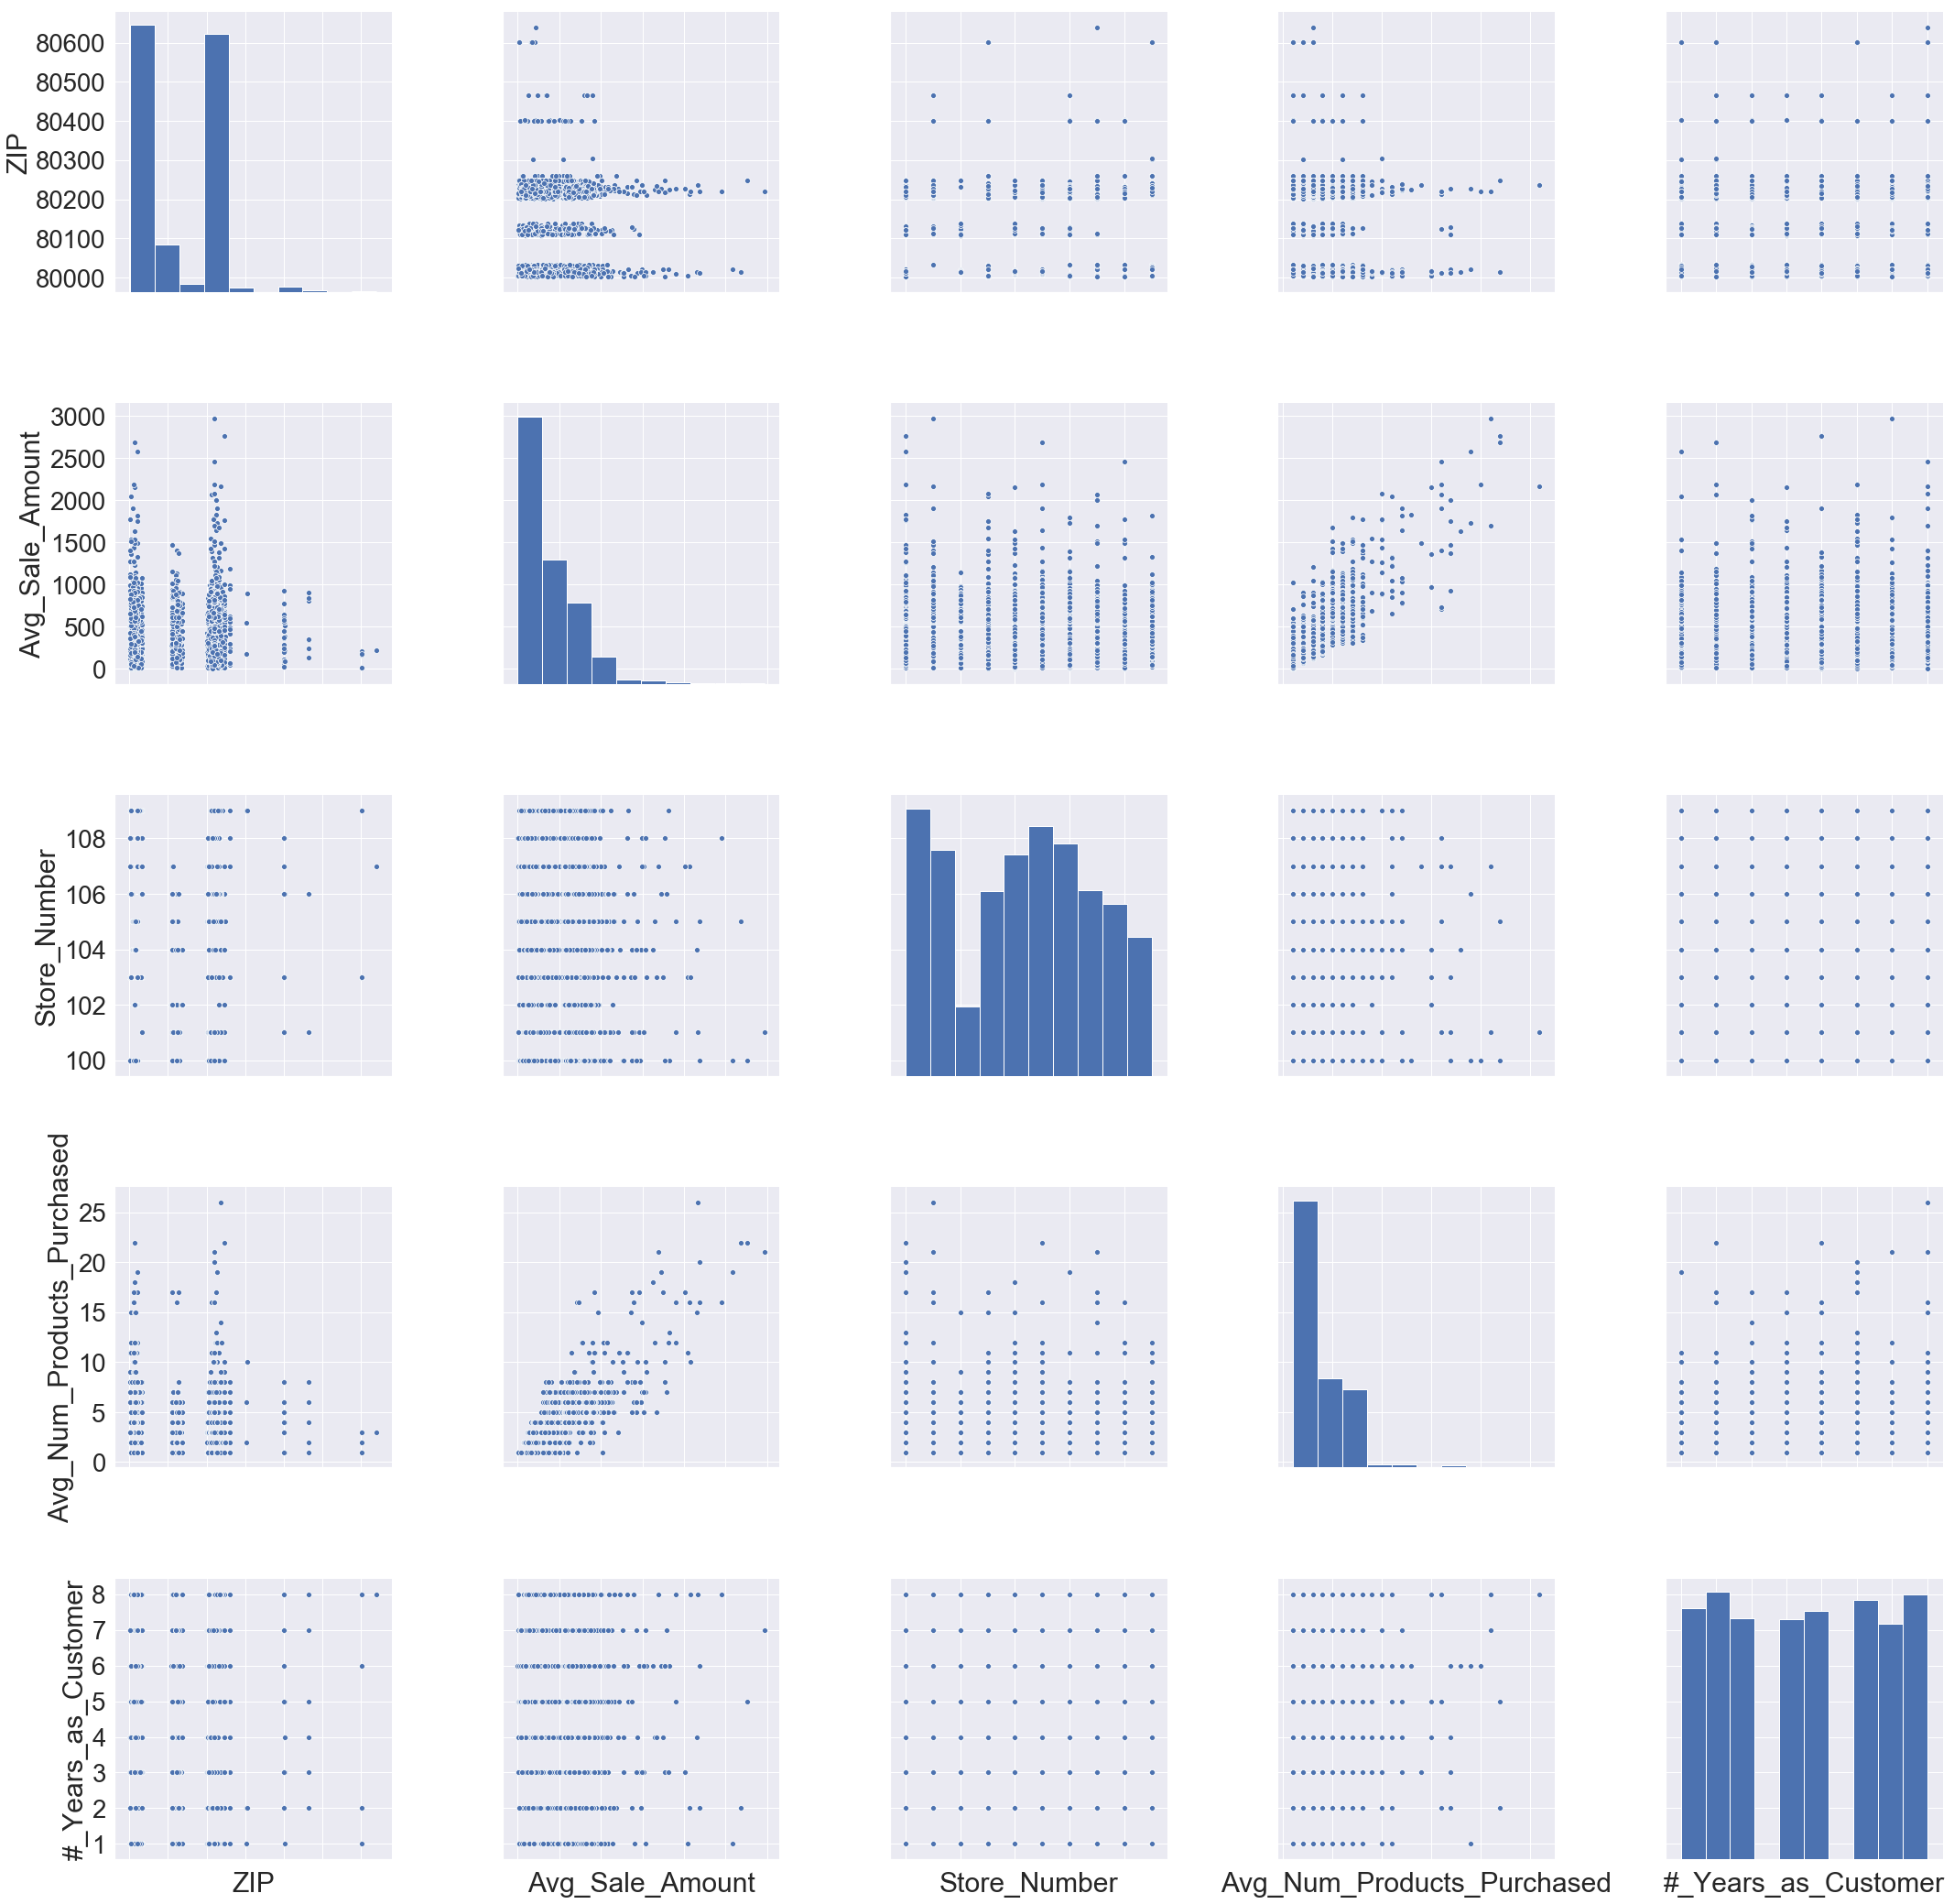

In [15]:
#understanding the distribution with seaborn
with sns.plotting_context("notebook",font_scale=2.5):
    g = sns.pairplot(customers[['Customer_Segment','City','ZIP','Avg_Sale_Amount','Store_Number','Avg_Num_Products_Purchased','#_Years_as_Customer']], 
                 palette='tab20',size=6)
g.set(xticklabels=[]);

plt.show()

Let's take a closer look at the relationship between the numeric features and the target variable `Avg_Sale_Amount`.

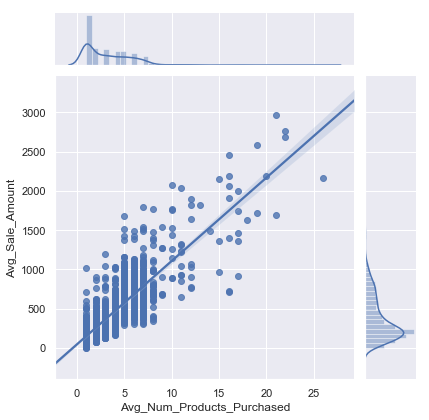

In [16]:
sns.jointplot(x="Avg_Num_Products_Purchased", y="Avg_Sale_Amount", data=customers, kind="reg")
plt.show()

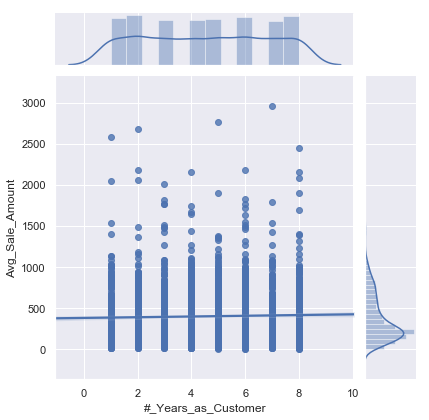

In [17]:
sns.jointplot(x="#_Years_as_Customer", y="Avg_Sale_Amount", data=customers, kind="reg")
plt.show()

## Multiple linear regression

In [18]:
customers = customers.rename(columns = {'#_Years_as_Customer':'Num_Years_as_Customer'})

In [19]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2375 entries, 0 to 2374
Data columns (total 7 columns):
Customer_Segment              2375 non-null object
City                          2375 non-null object
ZIP                           2375 non-null category
Avg_Sale_Amount               2375 non-null float64
Store_Number                  2375 non-null category
Avg_Num_Products_Purchased    2375 non-null int64
Num_Years_as_Customer         2375 non-null int64
dtypes: category(2), float64(1), int64(2), object(2)
memory usage: 101.1+ KB


In [20]:
model = ols("Avg_Sale_Amount ~ Avg_Num_Products_Purchased + Num_Years_as_Customer + Customer_Segment + City + ZIP + Store_Number", data=customers).fit()

In [21]:
model_summary = model.summary()

In [22]:
html = HTML(
(model_summary
    .as_html()
    .replace('<th>  Adj. R-squared:    </th>', '<th style="background-color:#aec7e8;"> Adj. R-squared: </th>')
    .replace('<th>coef</th>', '<th style="background-color:#ffbb78;">coef</th>')
    .replace('<th>std err</th>', '<th style="background-color:#c7e9c0;">std err</th>')
    .replace('<th>P>|t|</th>', '<th style="background-color:#bcbddc;">P>|t|</th>')
    .replace('<th>[0.025</th>    <th>0.975]</th>', '<th style="background-color:#ff9896;">[0.025</th>    <th style="background-color:#ff9896;">0.975]</th>'))
)

In [23]:
html

In [24]:
with open('reg_output.html', 'w') as f:
    f.write(html.data)

**Adj. R-squared** indicates that 83.60% of the average sale amount can be explained by the given predictor variables.

**Regression coefficient (coef)** represents the change in the dependent variable resulting from a one unit change in the predictor variable, all other variables being held constant.

**Standard error** measures the accuracy of the above coefficients by estimating the variation of the coefficient if the same test were run on a different sample of our population. The lower the error, the more accurate.

**p-value** means the probability of the coefficient indicating a decrease/increase in target variable due to a one unit increase in each of the predictor variables. A low p-value indicates that the results are statistically significant, that is in general the p-value is less than 0.05.

**confidence interval** is a range within which our coefficient is likely to fall. We can be 95% confident that each predictor variable's coefficient will be within our confidence interval of the values in the two red columns.

Based on the p-values, `Customer_Segment` (0.000 for all three segment categories) and `Avg_Num_Products_Purchased` (0.000) are significant. The other variables have p > 0.05.

In [25]:
adj_model = ols("Avg_Sale_Amount ~ Avg_Num_Products_Purchased + Customer_Segment", data=customers).fit()

In [26]:
adj_model_summary = adj_model.summary()

In [27]:
HTML(
(adj_model_summary
    .as_html()
    .replace('<th>  Adj. R-squared:    </th>', '<th style="background-color:#aec7e8;"> Adj. R-squared: </th>')
    .replace('<th>coef</th>', '<th style="background-color:#ffbb78;">coef</th>')
    .replace('<th>std err</th>', '<th style="background-color:#c7e9c0;">std err</th>')
    .replace('<th>P>|t|</th>', '<th style="background-color:#bcbddc;">P>|t|</th>')
    .replace('<th>[0.025</th>    <th>0.975]</th>', '<th style="background-color:#ff9896;">[0.025</th>    <th style="background-color:#ff9896;">0.975]</th>'))
)

<hr>

# To predict

This dataset is the 250 customers that you need to predict sales. This is the list of customers that the company would send a catalog to. Use this dataset to estimate how much revenue the company can expect if they send out the catalog. It includes all of the fields from `P1_Customers.xlsx` except for `Responded_to_Last_Catalog` so this variable cannot be used in the linear regression model since it could not be applied to the mailing list data set. It also includes two additional variables.

* Score_No: The probability that the customer WILL NOT respond to the catalog and not make a purchase.
* Score_Yes: The probability that the customer WILL respond to the catalog and make a purchase.

Hint: We want to calculate the expected revenue from these 250 people in order to get expected profit. This means we need to multiply the probability that a person will buy our catalog as well. For example, if a customer were to buy from us, we predict this customer will buy \$450 worth of products. At a 30% chance that this person will actually buy from us, we can expect revenue to be \$450 x 30% = $135.

In [28]:
mailinglist = pd.read_excel('p1-mailinglist.xlsx')

In [29]:
#checking if any value is missing
print(mailinglist.isnull().any())

Name                          False
Customer_Segment              False
Customer_ID                   False
Address                       False
City                          False
State                         False
ZIP                           False
Store_Number                  False
Avg_Num_Products_Purchased    False
#_Years_as_Customer           False
Score_No                      False
Score_Yes                     False
dtype: bool


In [30]:
mailinglist.shape

(250, 12)

In [31]:
mailinglist.head()

,Name,Customer_Segment,Customer_ID,Address,City,State,ZIP,Store_Number,Avg_Num_Products_Purchased,#_Years_as_Customer,Score_No,Score_Yes
0,A Giametti,Loyalty Club Only,2213,5326 S Lisbon Way,Centennial,CO,80015,105,3,0.2,0.694964,0.305036
1,Abby Pierson,Loyalty Club and Credit Card,2785,4344 W Roanoke Pl,Denver,CO,80236,101,6,0.6,0.527275,0.472725
2,Adele Hallman,Loyalty Club Only,2931,5219 S Delaware St,Englewood,CO,80110,101,7,0.9,0.421118,0.578882
3,Alejandra Baird,Loyalty Club Only,2231,2301 Lawrence St,Denver,CO,80205,103,2,0.6,0.694862,0.305138
4,Alice Dewitt,Loyalty Club Only,2530,5549 S Hannibal Way,Centennial,CO,80015,104,4,0.5,0.612294,0.387706


In [32]:
mailinglist = mailinglist.drop(['Name', 'Address', 'Customer_ID'], axis=1)

In [33]:
mailinglist.shape

(250, 9)

In [34]:
mailinglist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 9 columns):
Customer_Segment              250 non-null object
City                          250 non-null object
State                         250 non-null object
ZIP                           250 non-null int64
Store_Number                  250 non-null int64
Avg_Num_Products_Purchased    250 non-null int64
#_Years_as_Customer           250 non-null float64
Score_No                      250 non-null float64
Score_Yes                     250 non-null float64
dtypes: float64(3), int64(3), object(3)
memory usage: 17.7+ KB


In [35]:
mailinglist.Customer_Segment.value_counts()

Loyalty Club Only               122
Credit Card Only                 82
Loyalty Club and Credit Card     26
Store Mailing List               20
Name: Customer_Segment, dtype: int64

In [36]:
mailinglist = mailinglist.rename(columns = {'#_Years_as_Customer':'Num_Years_as_Customer'})

In [37]:
pred = adj_model.predict(mailinglist)

In [44]:
mailinglist['Pred'] = pred

In [45]:
mailinglist['Exp_Sales'] = mailinglist['Pred'] * mailinglist['Score_Yes']

In [46]:
mailinglist['Exp_Sales'].sum()

47224.8713730907

In [47]:
(mailinglist['Exp_Sales'].sum() * 0.5) - (6.50 * 250)

21987.43568654535

<hr>